In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-rent-prices-of-metropolitan-cities-in-india/Delhi_rent.csv
/kaggle/input/house-rent-prices-of-metropolitan-cities-in-india/_All_Cities_Cleaned.csv
/kaggle/input/house-rent-prices-of-metropolitan-cities-in-india/Chennai_rent.csv
/kaggle/input/house-rent-prices-of-metropolitan-cities-in-india/Pune_rent.csv
/kaggle/input/house-rent-prices-of-metropolitan-cities-in-india/Bangalore_rent.csv
/kaggle/input/house-rent-prices-of-metropolitan-cities-in-india/Kolkata_rent.csv
/kaggle/input/house-rent-prices-of-metropolitan-cities-in-india/Ahmedabad_rent.csv
/kaggle/input/house-rent-prices-of-metropolitan-cities-in-india/Mumbai_rent.csv
/kaggle/input/house-rent-prices-of-metropolitan-cities-in-india/Hyderabad_rent.csv


# **Online Rental Properties Analysis**

**Project: Online Property Rental **
     In this project we have tried to find out the reliability of different features of real estate market upon each other and have tried to categorise rental proprerties to oprtimise its market. 

* importing necessary libraries


In [2]:
import seaborn as sns
import math
import plotly.express as px

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

**Importing Dataset**
This dataset is imported from kaggle and contains information on rental properties and their features from 8 metropolitan cities in India.  

In [3]:
rental_housing= pd.read_csv('/kaggle/input/house-rent-prices-of-metropolitan-cities-in-india/_All_Cities_Cleaned.csv')
rental_housing.head()

,seller_type,bedroom,layout_type,property_type,locality,price,area,furnish_type,bathroom,city
0,OWNER,2.0,BHK,Apartment,Bodakdev,20000.0,1450.0,Furnished,2.0,Ahmedabad
1,OWNER,1.0,RK,Studio Apartment,CG Road,7350.0,210.0,Semi-Furnished,1.0,Ahmedabad
2,OWNER,3.0,BHK,Apartment,Jodhpur,22000.0,1900.0,Unfurnished,3.0,Ahmedabad
3,OWNER,2.0,BHK,Independent House,Sanand,13000.0,1285.0,Semi-Furnished,2.0,Ahmedabad
4,OWNER,2.0,BHK,Independent House,Navrangpura,18000.0,1600.0,Furnished,2.0,Ahmedabad


> Total entries in the data is 193011, where none of the columns have null values.There are primarily two data types in the data float64 and object.

In [4]:
rental_housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193011 entries, 0 to 193010
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   seller_type    193011 non-null  object 
 1   bedroom        193011 non-null  float64
 2   layout_type    193011 non-null  object 
 3   property_type  193011 non-null  object 
 4   locality       193011 non-null  object 
 5   price          193011 non-null  float64
 6   area           193011 non-null  float64
 7   furnish_type   193011 non-null  object 
 8   bathroom       193011 non-null  float64
 9   city           193011 non-null  object 
dtypes: float64(4), object(6)
memory usage: 14.7+ MB


In [5]:
rental_housing.shape

(193011, 10)

In [6]:
rental_housing.loc[:,['seller_type','layout_type','property_type','furnish_type']].value_counts()

seller_type  layout_type  property_type      furnish_type  
AGENT        BHK          Apartment          Semi-Furnished    57211
                                             Unfurnished       33816
                                             Furnished         27297
OWNER        BHK          Apartment          Semi-Furnished    11793
AGENT        BHK          Independent Floor  Semi-Furnished     9906
                                             Unfurnished        6995
OWNER        BHK          Apartment          Unfurnished        5763
                          Independent Floor  Semi-Furnished     3994
AGENT        BHK          Independent House  Semi-Furnished     3907
OWNER        BHK          Independent House  Semi-Furnished     3693
AGENT        BHK          Independent Floor  Furnished          3351
OWNER        BHK          Apartment          Furnished          3249
                          Independent House  Unfurnished        2459
                          Independent Floor

**Pre-processing**
Count of categorical variables and finding the mistakes and unassigned values in the data.

In [7]:
print(pd.isnull(rental_housing).sum())

seller_type      0
bedroom          0
layout_type      0
property_type    0
locality         0
price            0
area             0
furnish_type     0
bathroom         0
city             0
dtype: int64


In [8]:
rental_housing=rental_housing.replace('',np.nan)
rental_housing= rental_housing.dropna()
rental_housing.shape

(193011, 10)

> Finding the duplicate rows in the data and dropping the duplicates.

In [9]:

rental_housing.duplicated().sum()



85398

In [10]:
rental_housing.drop_duplicates(keep='first',inplace=True)
rental_housing.shape


(107613, 10)

> Removing outliers using Interquartile Range

In [11]:
# Removing the outliers using Interquartile Range for all columns

def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
      
    print("IQR value for column %s is: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data
      
    lower_range = Q1 - 0.5 * IQR
    upper_range = Q3 + 2.5 * IQR
    print(lower_range,upper_range)
    outlier_free_list = [x for x in data[col] if (  (x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]

out_columns = rental_housing[['price', 'area']]  
for i in out_columns:
    removeOutliers(rental_housing, i)
  
# Assigning filtered data back to our original variable'

rental_housing = filtered_data
print("Shape of data after outlier removal is: ", rental_housing.shape)

IQR value for column price is: 24000.0
1000.0 97000.0
IQR value for column area is: 800.0
250.0 3450.0
Shape of data after outlier removal is:  (101071, 10)


The range of data after hte out;ier removal is set between 

In [12]:
rental_housing.describe()

,bedroom,price,area,bathroom
count,101071.000000,1.010710e+05,101071.000000,101071.000000
mean,2.006589,3.196083e+04,1104.170890,1.969289
std,0.834390,4.213891e+04,568.984528,0.808047
min,1.000000,1.500000e+03,251.000000,1.000000
25%,1.000000,1.300000e+04,650.000000,1.000000
50%,2.000000,2.000000e+04,1000.000000,2.000000
75%,3.000000,3.400000e+04,1350.000000,2.000000
max,8.000000,1.200000e+06,3443.000000,9.000000


**Copying the Original dataset,chosing to operate and test on a copy.**

In [13]:
renhou=rental_housing.copy()
renhou

,seller_type,bedroom,layout_type,property_type,locality,price,area,furnish_type,bathroom,city
0,OWNER,2.0,BHK,Apartment,Bodakdev,20000.0,1450.0,Furnished,2.0,Ahmedabad
2,OWNER,3.0,BHK,Apartment,Jodhpur,22000.0,1900.0,Unfurnished,3.0,Ahmedabad
3,OWNER,2.0,BHK,Independent House,Sanand,13000.0,1285.0,Semi-Furnished,2.0,Ahmedabad
4,OWNER,2.0,BHK,Independent House,Navrangpura,18000.0,1600.0,Furnished,2.0,Ahmedabad
5,OWNER,1.0,BHK,Apartment,Vejalpur,8500.0,570.0,Unfurnished,1.0,Ahmedabad
...,...,...,...,...,...,...,...,...,...,...
193006,OWNER,1.0,BHK,Apartment,Chinchwad,13250.0,650.0,Semi-Furnished,1.0,Pune
193007,OWNER,1.0,RK,Studio Apartment,Wadgaon Sheri,7000.0,350.0,Unfurnished,1.0,Pune
193008,OWNER,1.0,BHK,Apartment,Kothrud,8500.0,389.0,Semi-Furnished,1.0,Pune
193009,AGENT,1.0,BHK,Apartment,Wakad,16500.0,670.0,Semi-Furnished,2.0,Pune


Taking the copy of the dataset and performing visualisations on the cleaned and corrected data to understad the various trend of the data and their correlations. 

<AxesSubplot:xlabel='city', ylabel='price'>

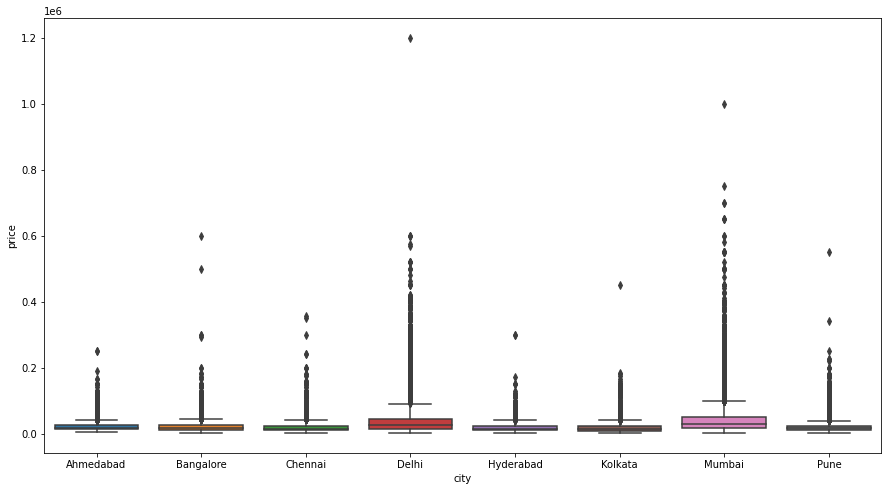

In [14]:
figure = plt.figure(figsize=(15,8))
sns.boxplot(x='city',y='price',data=renhou)

> Boxplot of price of properties and respective cities. 

<AxesSubplot:xlabel='seller_type', ylabel='price'>

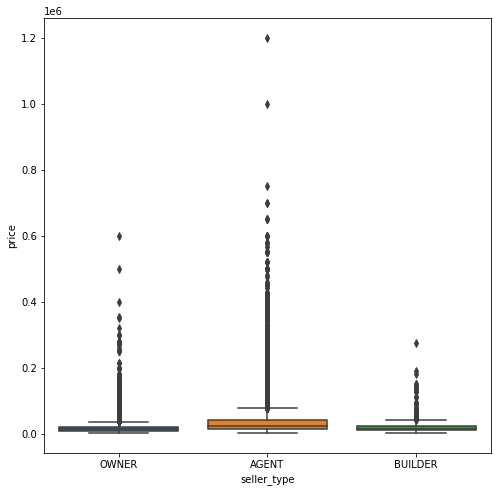

In [15]:
figure = plt.figure(figsize=(8,8))
sns.boxplot(x='seller_type',y='price',data=renhou)

> Boxplot - Seller type vs price

<AxesSubplot:xlabel='furnish_type', ylabel='price'>

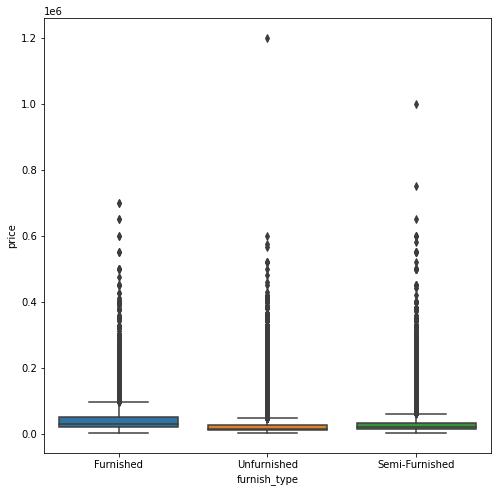

In [16]:
figure = plt.figure(figsize=(8,8))
sns.boxplot(x='furnish_type',y='price',data=renhou)

> Boxplot- Furnishing vs Price

From the boxplots with price on the Y axis we get the idea that
* Properties of maximum prices are from Delhi and Mumbai in general.
* Agent sold properties are more in number and have highest priced properties than    Builder and Owner sold properties.
* Fully Furnished Properties are more in quantity but the highest priced properties are semi-furnished and unfurnished properties.

**Count analysis of properties**
here, we have done Countplot of properties and have tried to find the density of various features in the data. 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


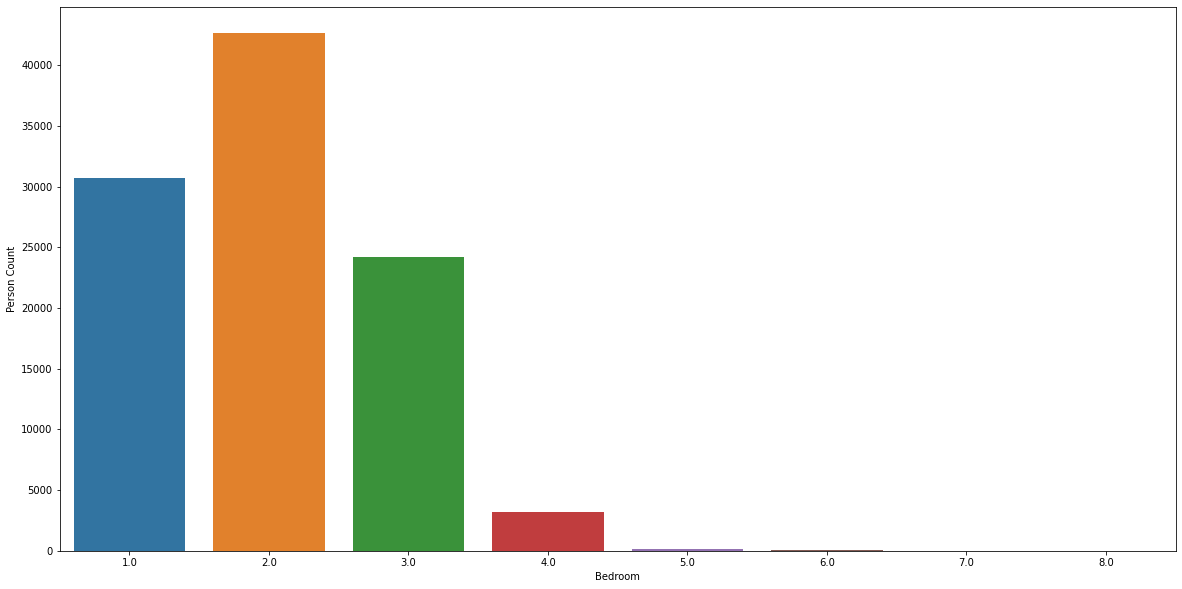

In [17]:
plt.figure(figsize=(20,10))
sns.countplot(renhou.bedroom)
plt.xlabel("Bedroom")
plt.ylabel("Person Count")
plt.show()

> Person count vs Bedroom

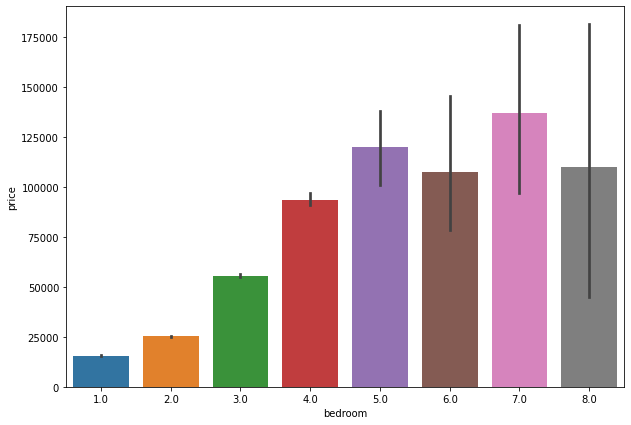

In [18]:
plt.figure(figsize=(10,7))
ax=sns.barplot(x='bedroom',y='price',data=renhou)

      Barplot- Bedroom vs Price 

From the data, we can surmise 
* Maximum number of the properties consists of two bedrooms.
* seconding it with one bedroom and thirdly three bedrooms.
From this observation we get that most of the properties ranges between 1-3 bedrooms and the 2 bedroom is the most popualar of the lot, followed by one bedroom and three bedrooms.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


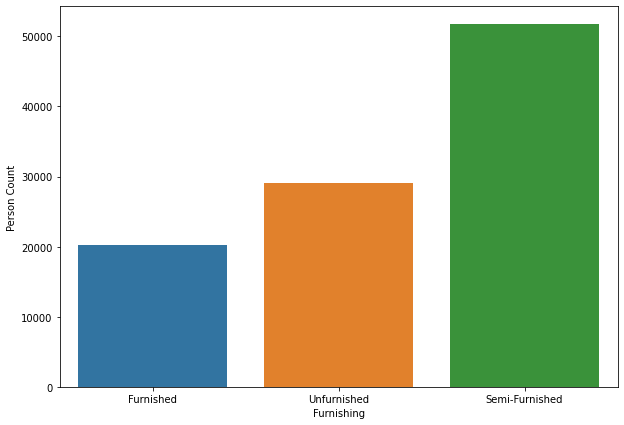

In [19]:
plt.figure(figsize=(10,7))
sns.countplot(renhou.furnish_type)
plt.xlabel("Furnishing")
plt.ylabel("Person Count")
plt.show()

Furnishing vs PersonCount

<AxesSubplot:xlabel='Count', ylabel='price'>

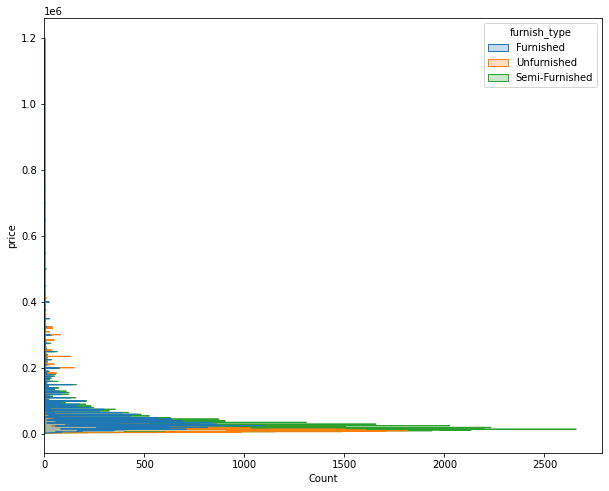

In [20]:
plt.figure(figsize=(10,8))
sns.histplot(data=renhou,y='price',hue='furnish_type',element='step')

     Histplot- Count vs Price

* maximum number of properties are Semifurnished, followed by unfurnished and fully furnished.
this shows that there is a higher demand of semifurnished properties in the market.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


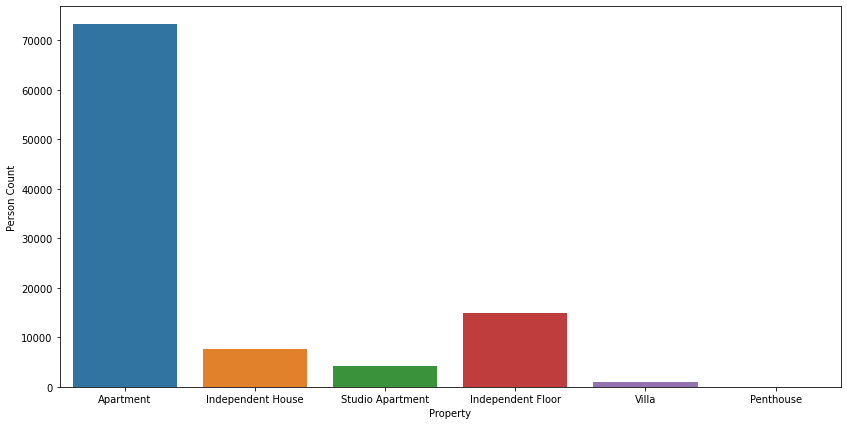

In [21]:
plt.figure(figsize=(14,7))
sns.countplot(renhou.property_type)
plt.xlabel("Property")
plt.ylabel("Person Count")
plt.show()

Property Type vs PersonCount

<AxesSubplot:xlabel='Count', ylabel='area'>

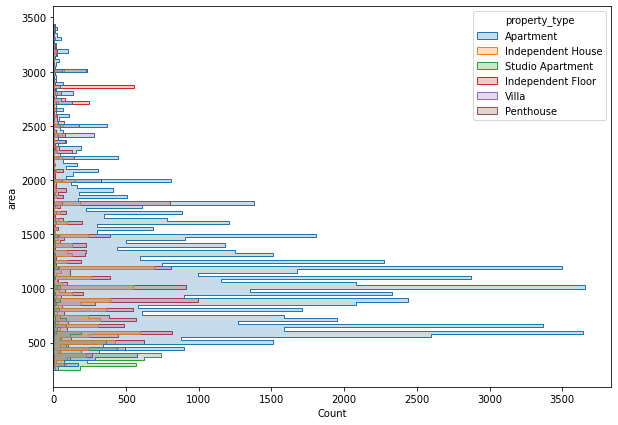

In [22]:
plt.figure(figsize=(10,7))
sns.histplot(data=renhou,y='area',hue='property_type',element='step')

Histplot- Area vs Count

This plot denotes the number of specific type of properties in the market.
* The highest number of properties in the market are Apartments.
* The least number is the Penthouse.

<AxesSubplot:xlabel='Count', ylabel='price'>

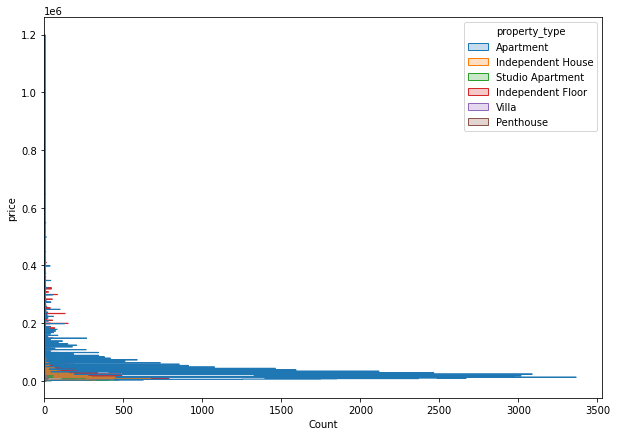

In [23]:
plt.figure(figsize=(10,7))
sns.histplot(data=renhou,y='price',hue='property_type',element='step')

     Histplot- Price vs Count

Further, referencing the property types with the price range, we observe


* > Most of the properties, which are apartments lie between the range of 9-11 from the plot.
* > Apartments are found in nearly all price ranges.
* > Independent floor are generally expensive than rest of the property types.
* > Studio Apartments are generally cheaper.


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


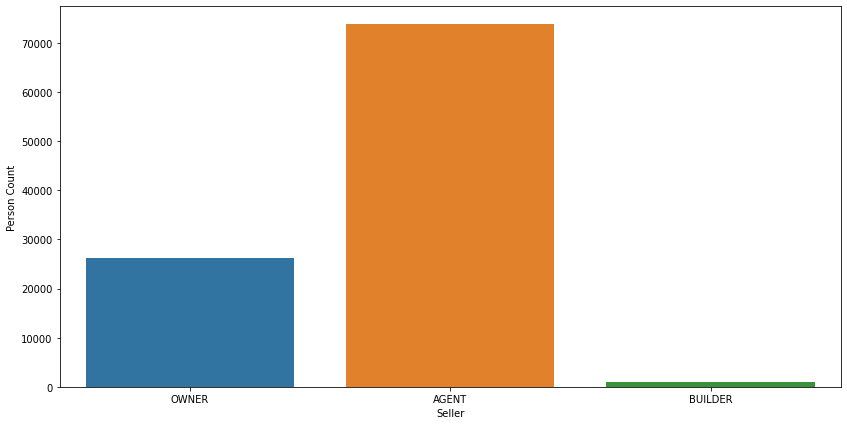

In [24]:
plt.figure(figsize=(14,7))
sns.countplot(renhou.seller_type)
plt.xlabel("Seller")
plt.ylabel("Person Count")
plt.show()

> Histplot- Seller vs PersonCount

<AxesSubplot:xlabel='Count', ylabel='price'>

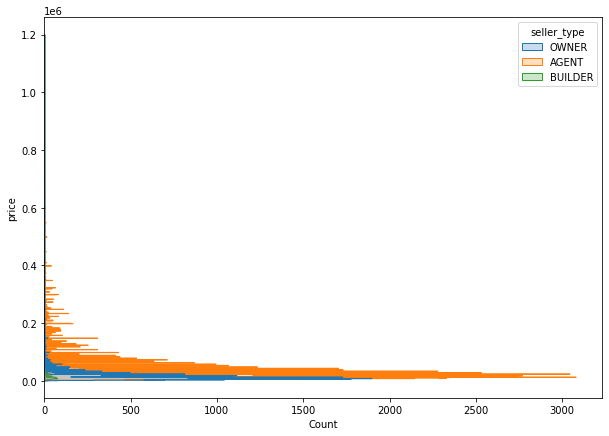

In [25]:

plt.figure(figsize=(10,7))
sns.histplot(data=renhou,y='price',hue='seller_type',element='step')

    HIstplot- Count vs Price

<Figure size 720x504 with 0 Axes>

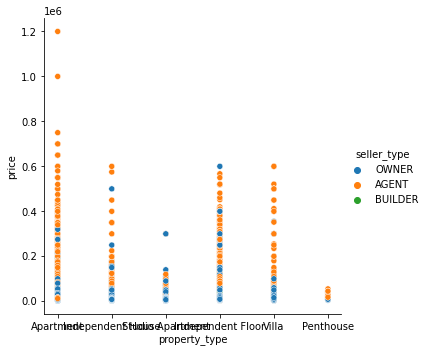

In [26]:
plt.figure(figsize=(10,7))
sns.relplot(data=renhou,y='price',x='property_type',hue='seller_type')

<Figure size 1080x504 with 0 Axes>

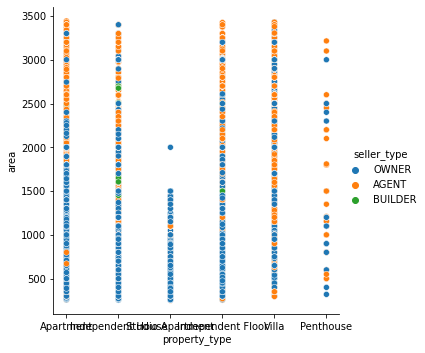

In [27]:
plt.figure(figsize=(15,7))
sns.relplot(data=renhou,y='area',x='property_type',hue='seller_type')

> Agent sold properties are highest in number in comparison, whereas Builder sold properties are the lowest.
> Owner sold properties lie in a lower price range than Agent sold properties.
> Expersive Properties are almost entirely Agent sold.


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


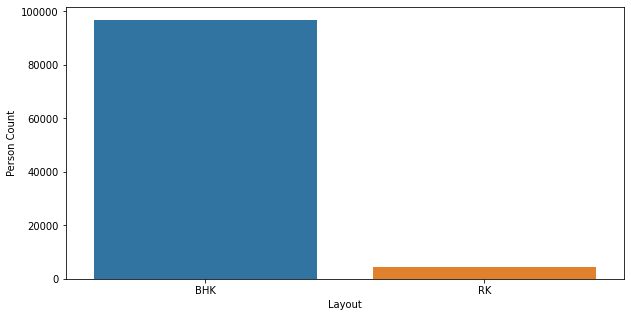

In [28]:
plt.figure(figsize=(10,5))
sns.countplot(renhou.layout_type)
plt.xlabel("Layout")
plt.ylabel("Person Count")
plt.show()

        Countplot- Layout vs PersonCount

<AxesSubplot:xlabel='Count', ylabel='area'>

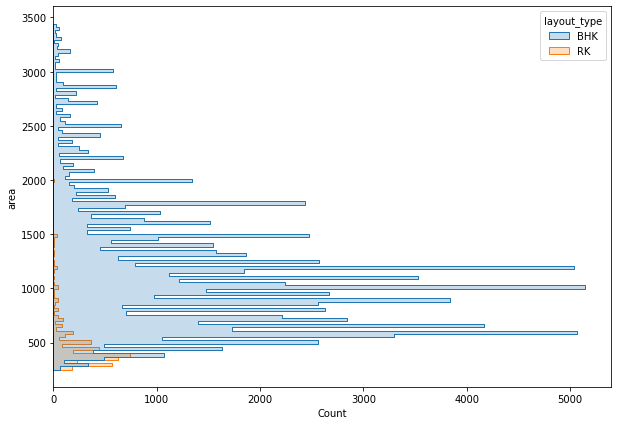

In [29]:
plt.figure(figsize=(10,7))
sns.histplot(data=renhou,y='area',hue='layout_type',element='step')

     Histplot- Count vs Area

In terms of Layout type, the properties are divided into two subtypes the BHK type and the RK type. The data plots shows us that
* A very large number of properties are in the BHK layout and only few are in the RK layout.
* RK layout has very less area coverage.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


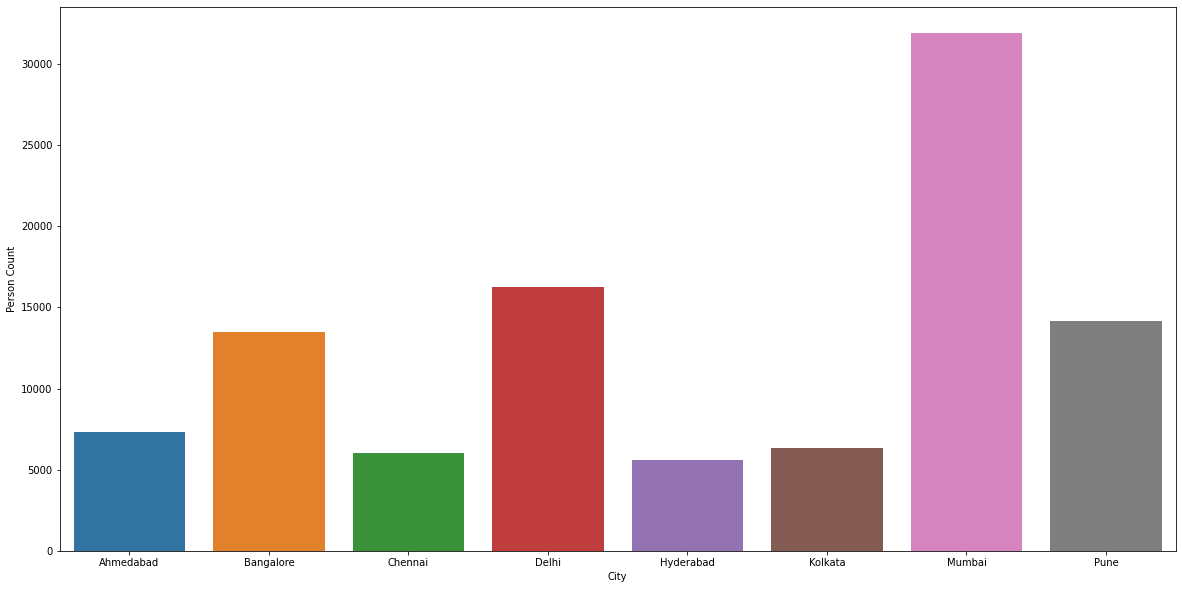

In [30]:
plt.figure(figsize=(20,10))
sns.countplot(renhou.city)
plt.xlabel("City")
plt.ylabel("Person Count")
plt.show()

     Countplot- City vs Count

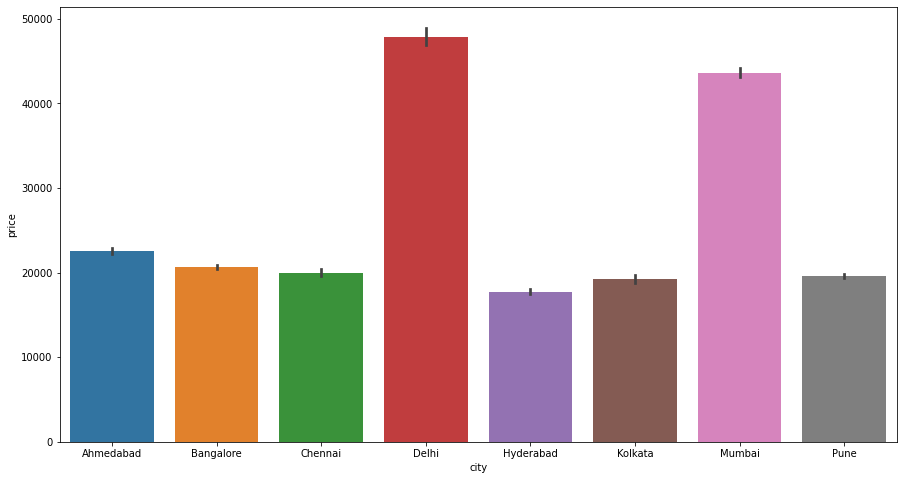

In [31]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x='city',y='price',data=renhou)

     Barplot- City vs Price

<AxesSubplot:xlabel='Count', ylabel='price'>

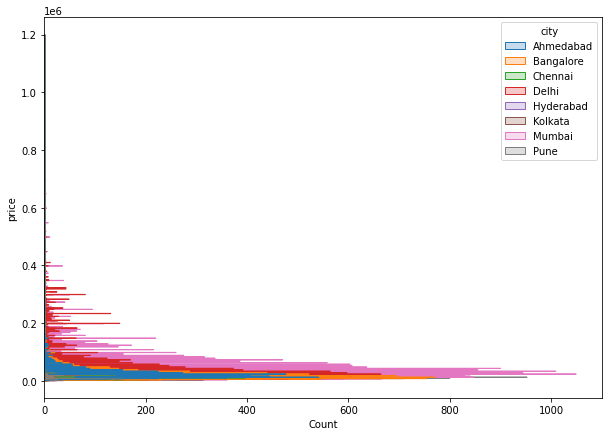

In [32]:
plt.figure(figsize=(10,7))
sns.histplot(data=renhou,y='price',hue='city',element='step')

     Histplot- City vs Price

<AxesSubplot:xlabel='Count', ylabel='area'>

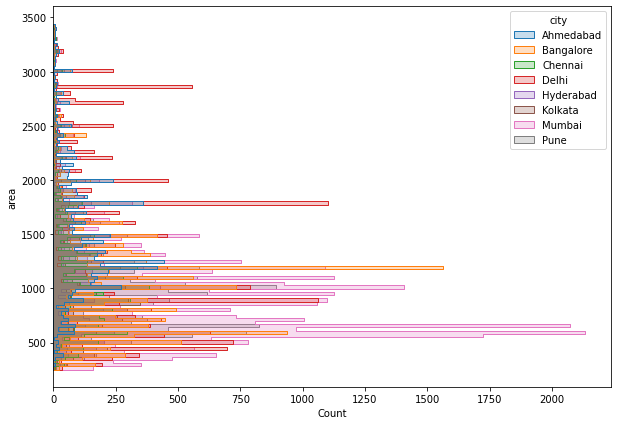

In [33]:
plt.figure(figsize=(10,7))
sns.histplot(data=renhou,y='area',hue='city',element='step')

     Histplot- Count vs Area

<Figure size 1440x720 with 0 Axes>

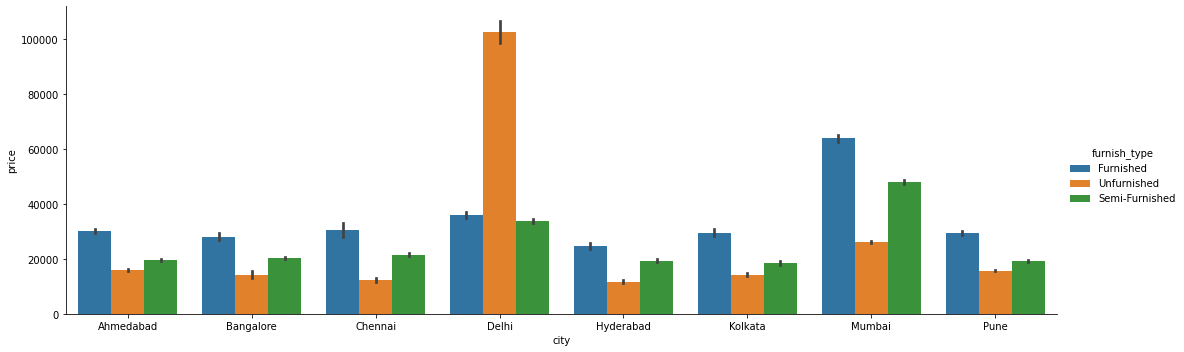

In [34]:

plt.figure(figsize=(20,10))
sns.catplot(x="city", y="price",hue='furnish_type',data=renhou,kind='bar',height=5,aspect=3)

     Catplot- City vs Price(by Furnishing type)

The observations in the data are a culmination of real estate rental properties situated in 8 cities namely Ahmedabad,Bangalore,Chennai, Delhi,Hyderabad,Kolkata,Mumbai and Pune. The data features various aspects of the properties in these locations which provides us with the following insights by location:
* There are more number of properties located at Mumbai inferencing that there are more properties in general for rent in Mumbai. Its almost twice the number of rental properties in Delhi, which stands in the second position.
* All the cities contains properties of high prices in general but Mumbai and Delhi have slighly expensive properties.
* Delhi contains properties that have greater area coverage than any other city, or in other terms Delhi have more big properties.
* On the basis of Furnishing types, the properties in various cities shows nearly similar trends that is,mumbai having the most number of properties contains most number of Furnished properties, then Semi furnished and then the Unfurnished type. All other cities, except Delhi follows the same order.Delhi has more number of unfurnished properties than Furnished and semi furnished types.  



<AxesSubplot:xlabel='price', ylabel='Density'>

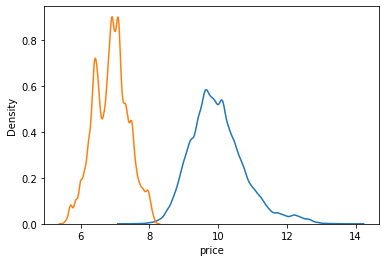

In [35]:
renhou["price"]=np.log(renhou["price"])
renhou["area"]=np.log(renhou["area"])
sns.kdeplot(renhou["price"])
sns.kdeplot(renhou["area"])

# Area and Prices of properties by location 

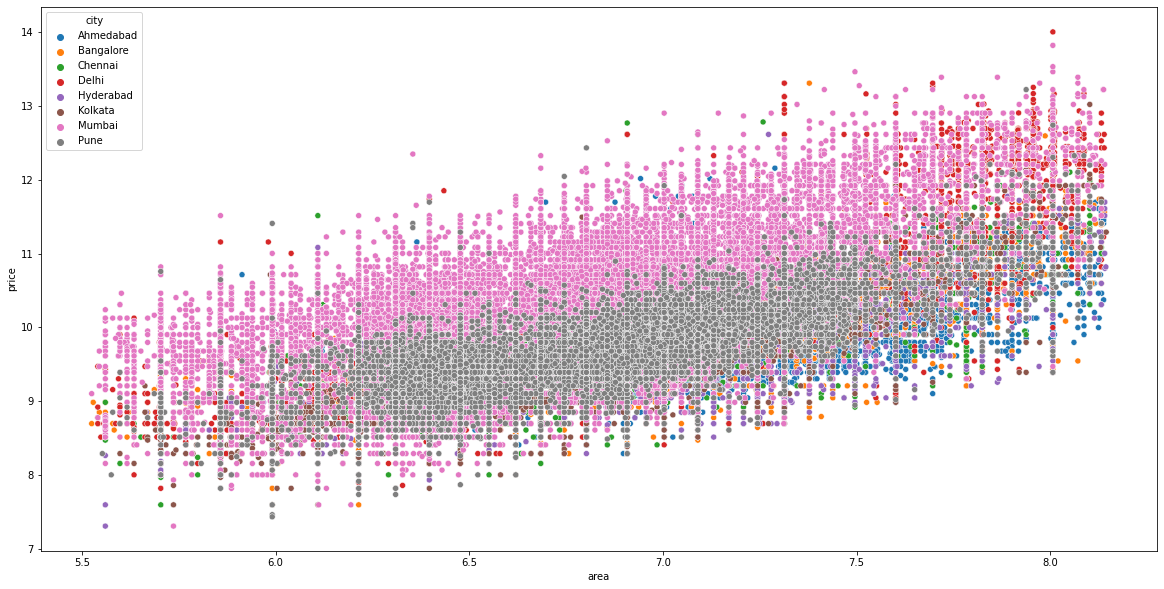

In [36]:
sns.scatterplot(x='area', y='price', data=renhou, hue='city')
plt.gcf().set_size_inches(20,10)
plt.show()

     Scatterplot- Area vs Price

> This Scatter plot shows how the data has been spread over with respect to area and their respective prices throughout the 8 cities.

Generating Correlation between the numerical columns of the initial data and visualising it through the heatmap.

In [37]:
renhou.corr()

,bedroom,price,area,bathroom
bedroom,1.000000,0.580301,0.829809,0.825390
price,0.580301,1.000000,0.624681,0.611404
area,0.829809,0.624681,1.000000,0.777393
bathroom,0.825390,0.611404,0.777393,1.000000


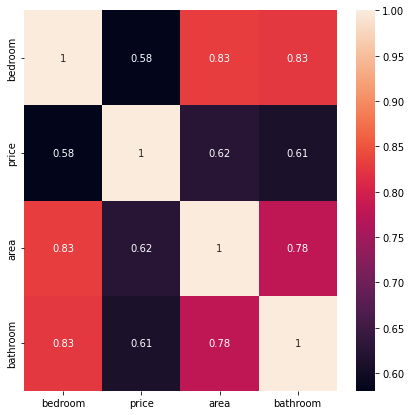

In [38]:
plt.figure(figsize=(7,7))
sns.heatmap(renhou.corr(), annot=True)
plt.show()

      Initial Heatmap

**Performing Kmeans**

Taking the two continous data columns in the dataset to create a separate dataframe and performing Kmeans Analysis to it. The model should be able to segregate or cluster the continous data into various groups of recognisable patterns.The Area and Price values of the properties of the entire data should provide us the variation in price of properties in terms of the area in the current Real Estate market. 

In [39]:
renhou_num=renhou[['area','price']]
renhou_num

,area,price
0,7.279319,9.903488
2,7.549609,9.998798
3,7.158514,9.472705
4,7.377759,9.798127
5,6.345636,9.047821
...,...,...
193006,6.476972,9.491753
193007,5.857933,8.853665
193008,5.963579,9.047821
193009,6.507278,9.711116


In [40]:
renhou_num.corr()

,area,price
area,1.000000,0.624681
price,0.624681,1.000000


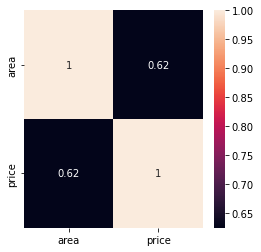

In [41]:
plt.figure(figsize=(4,4))
sns.heatmap(renhou_num.corr(), annot=True)
plt.show()

**Determining the number of clusters through Elbow Curve**

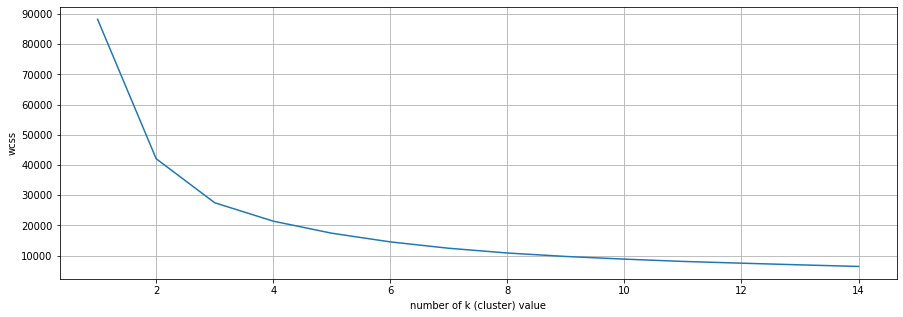

In [42]:
#define k value
wcss = []
for k in range(1,15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(renhou_num)
    wcss.append(kmeans.inertia_)

# the best value is elbow value. It's 3
plt.figure(figsize=(15,5))
plt.plot(range(1,15),wcss)
plt.xlabel("number of k (cluster) value")
plt.ylabel("wcss")
plt.grid()
plt.show()


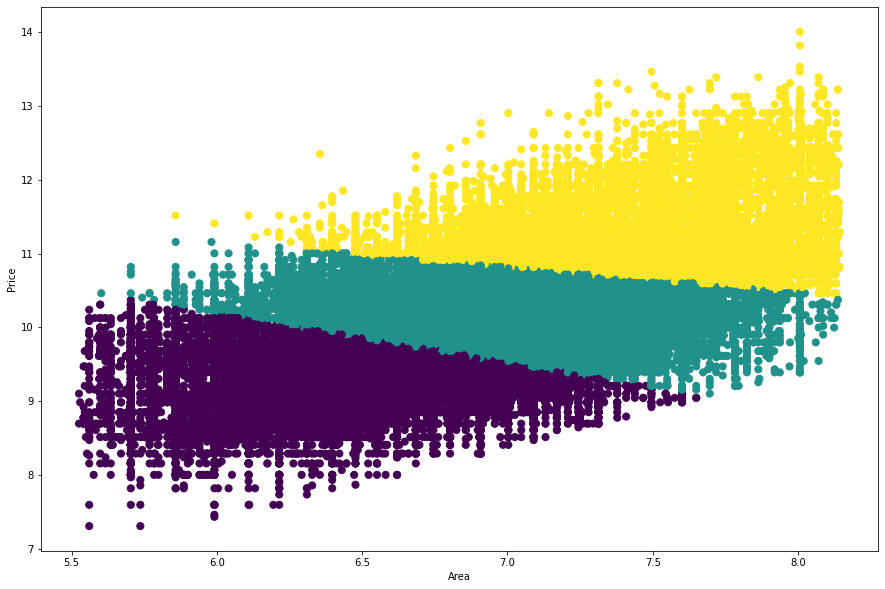

In [43]:
#create model
kmeans = KMeans(n_clusters=3)
rent_predict = kmeans.fit_predict(renhou_num)

plt.figure(figsize=(15,10))
plt.scatter( x = 'area' ,y = 'price' , data = renhou_num, c = rent_predict, s = 50 )
plt.xlabel("Area")
plt.ylabel("Price")
plt.show()

**Area vs Price Segmentation**
From the elbow curve, choosing the number of clusters=3.The scatter plot of the segmented data on the basis of price and area coverage of properties are shown above.
After performing the Kmeans cluster analysis, the data can be segmented into three parts-


* > The Price ranging from normalised 7 to 10. It is the range in which the lower range houses belong usually having maximum area of normalised 7-7.5. These properties are usually expected to be inhabited by Bachelors and Small families.
* > The Price ranging from normalised 10-11.It is the range in which the medium range houses belong, its a small mid partison zone where properties of area of normalised maximum area of 7.5 belongs. This is the properties range where Upper middle class or large families resides.
* > The Price ranging from normalised 11 to 14 and above is the highly priced properties, with maximum area coverage of more than 8. This are the bunch of expensive properties usually rented by elites and rich.

**Creating Dummy variables to store the categorical responses as values**

In [44]:


#Creating dummy variables
sellertype_dummy = pd.get_dummies(renhou['seller_type'])
layouttype_dummy = pd.get_dummies(renhou['layout_type'])
propertytype_dummy = pd.get_dummies(renhou['property_type'])
furnishtype_dummy = pd.get_dummies(renhou['furnish_type'])
city_dummy = pd.get_dummies(renhou['city'])
#Concatenating the dummy variables to the original dataset
renhou_dummy=pd.concat([renhou,sellertype_dummy,
layouttype_dummy,propertytype_dummy,furnishtype_dummy,city_dummy],axis=1)
#Deleting categorical variable from the dummy set
del renhou_dummy['seller_type']
del renhou_dummy['layout_type']
del renhou_dummy['property_type']
del renhou_dummy['furnish_type']
del renhou_dummy['city']
renhou_dummy

,bedroom,locality,price,area,bathroom,AGENT,BUILDER,OWNER,BHK,RK,...,Semi-Furnished,Unfurnished,Ahmedabad,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Pune
0,2.0,Bodakdev,9.903488,7.279319,2.0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
2,3.0,Jodhpur,9.998798,7.549609,3.0,0,0,1,1,0,...,0,1,1,0,0,0,0,0,0,0
3,2.0,Sanand,9.472705,7.158514,2.0,0,0,1,1,0,...,1,0,1,0,0,0,0,0,0,0
4,2.0,Navrangpura,9.798127,7.377759,2.0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
5,1.0,Vejalpur,9.047821,6.345636,1.0,0,0,1,1,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193006,1.0,Chinchwad,9.491753,6.476972,1.0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
193007,1.0,Wadgaon Sheri,8.853665,5.857933,1.0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
193008,1.0,Kothrud,9.047821,5.963579,1.0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
193009,1.0,Wakad,9.711116,6.507278,2.0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


Dropping the Locality column from the dummy dataset as it cannot be converted into utilisable data. 

In [45]:
renhou_dummy=renhou_dummy.drop(['locality'],axis=1)
renhou_dummy

,bedroom,price,area,bathroom,AGENT,BUILDER,OWNER,BHK,RK,Apartment,...,Semi-Furnished,Unfurnished,Ahmedabad,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Pune
0,2.0,9.903488,7.279319,2.0,0,0,1,1,0,1,...,0,0,1,0,0,0,0,0,0,0
2,3.0,9.998798,7.549609,3.0,0,0,1,1,0,1,...,0,1,1,0,0,0,0,0,0,0
3,2.0,9.472705,7.158514,2.0,0,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0
4,2.0,9.798127,7.377759,2.0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
5,1.0,9.047821,6.345636,1.0,0,0,1,1,0,1,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193006,1.0,9.491753,6.476972,1.0,0,0,1,1,0,1,...,1,0,0,0,0,0,0,0,0,1
193007,1.0,8.853665,5.857933,1.0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,1
193008,1.0,9.047821,5.963579,1.0,0,0,1,1,0,1,...,1,0,0,0,0,0,0,0,0,1
193009,1.0,9.711116,6.507278,2.0,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1


**Generating Heat map of the dummy dataset **

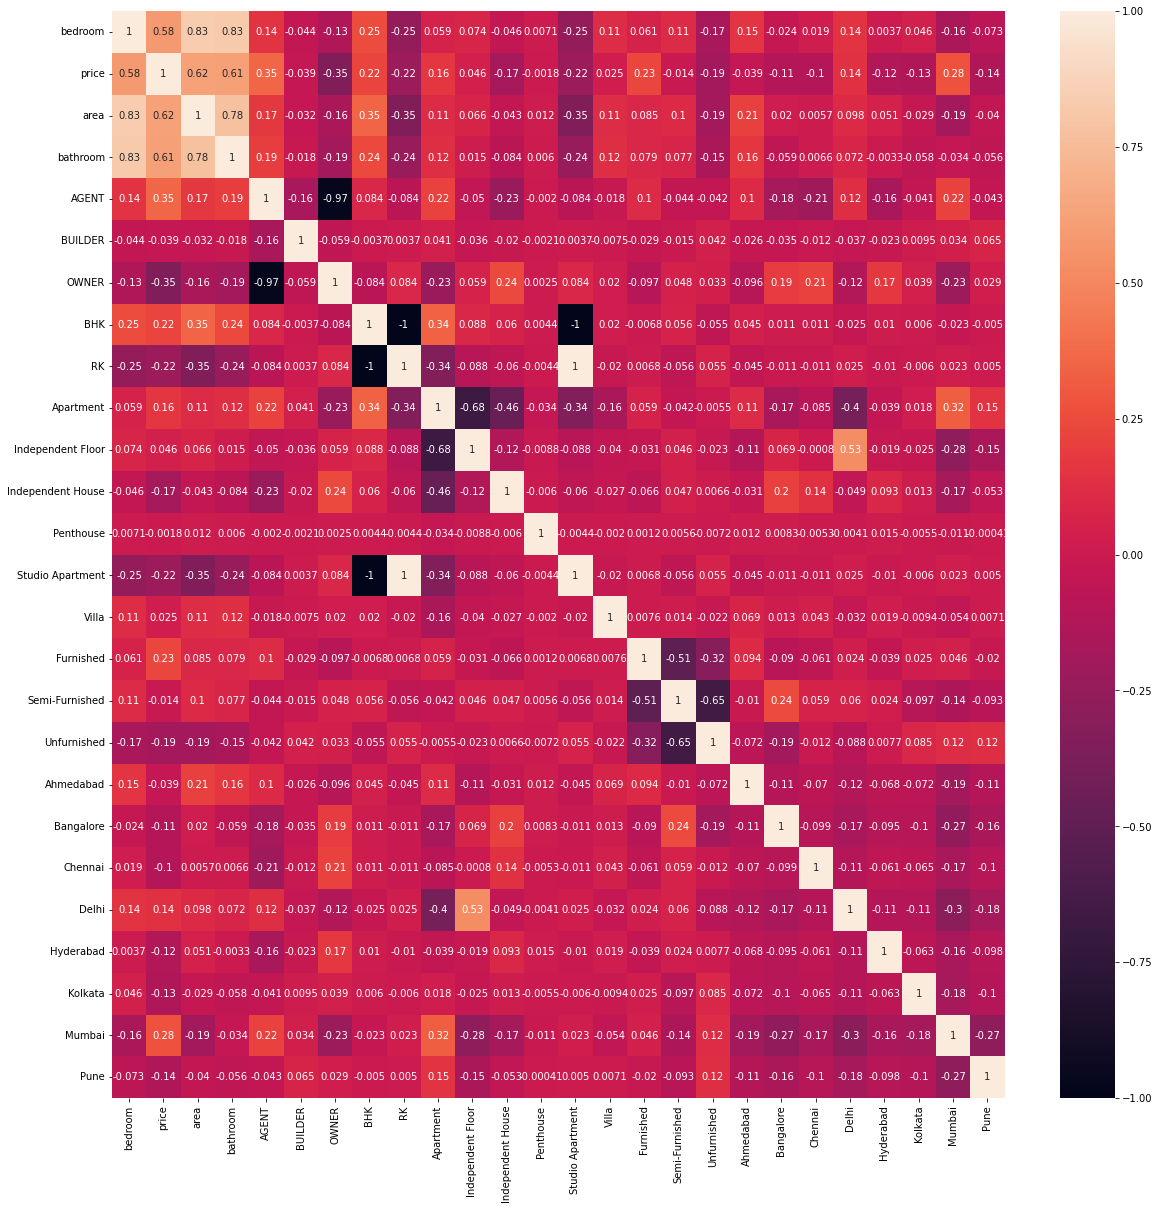

In [46]:
plt.figure(figsize=(20,20))
sns.heatmap(renhou_dummy.corr(), annot=True)
plt.show()

**Performing Kmeans of the dummy dataset and analysing the elbow curve**

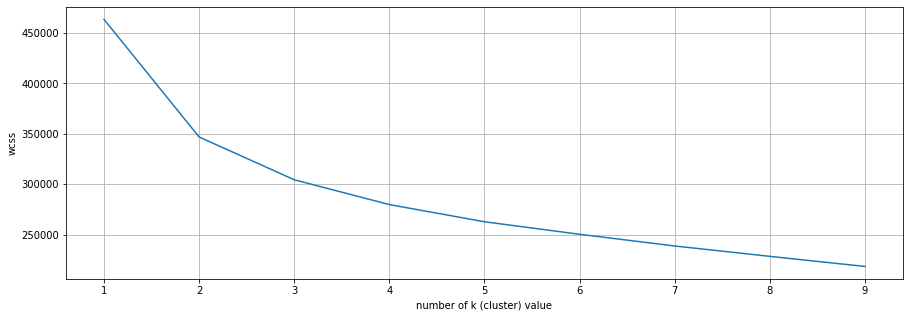

In [47]:
wcss = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(renhou_dummy)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(15,5))
plt.plot(range(1,10),wcss)
plt.xlabel("number of k (cluster) value")
plt.ylabel("wcss")
plt.grid()
plt.show()


In [48]:
kmeans=KMeans(n_clusters=3)
label=kmeans.fit_predict(renhou_dummy)
print(label)

[1 2 1 ... 0 1 1]


Taking a copy of the original dataset and appending the identified clusters to the original dataset.

In [49]:
#Appending the identified clusters to the original data
clustered_renhou = renhou.copy()
clustered_renhou['Cluster'] = label
print(clustered_renhou.sort_values(by='Cluster'))

       seller_type  bedroom layout_type      property_type  \
50639        AGENT      1.0         BHK  Independent Floor   
46601        OWNER      2.0         BHK          Apartment   
46600        OWNER      1.0         BHK  Independent House   
158820       AGENT      1.0         BHK          Apartment   
46598        OWNER      2.0         BHK  Independent Floor   
...            ...      ...         ...                ...   
126884       AGENT      4.0         BHK          Apartment   
160180       AGENT      3.0         BHK          Apartment   
160179       AGENT      3.0         BHK          Apartment   
80390        AGENT      3.0         BHK  Independent Floor   
155517       AGENT      3.0         BHK          Apartment   

                         locality      price      area    furnish_type  \
50639               Malviya Nagar   9.210340  6.214608     Unfurnished   
46601                    Oragadam   8.922658  6.476972     Unfurnished   
46600   Arcot Road Valasaravakkam

In [50]:
clustered_renhou.sort_values(by='Cluster').head(30000)

,seller_type,bedroom,layout_type,property_type,locality,price,area,furnish_type,bathroom,city,Cluster
50639,AGENT,1.0,BHK,Independent Floor,Malviya Nagar,9.210340,6.214608,Unfurnished,1.0,Delhi,0
46601,OWNER,2.0,BHK,Apartment,Oragadam,8.922658,6.476972,Unfurnished,2.0,Chennai,0
46600,OWNER,1.0,BHK,Independent House,Arcot Road Valasaravakkam,8.987197,6.620073,Unfurnished,1.0,Chennai,0
158820,AGENT,1.0,BHK,Apartment,Andheri West,10.645425,6.194405,Semi-Furnished,1.0,Mumbai,0
46598,OWNER,2.0,BHK,Independent Floor,Velachery,9.392662,6.907755,Semi-Furnished,1.0,Chennai,0
...,...,...,...,...,...,...,...,...,...,...,...
91799,OWNER,1.0,BHK,Independent House,Nagaram,8.517193,6.309918,Unfurnished,1.0,Hyderabad,0
173544,AGENT,1.0,RK,Studio Apartment,Tingre Nagar,9.011889,6.214608,Semi-Furnished,1.0,Pune,0
30367,AGENT,1.0,BHK,Apartment,CV Raman Nagar,9.210340,6.234411,Semi-Furnished,1.0,Bangalore,0
100900,OWNER,1.0,BHK,Apartment,Gariahat,9.392662,6.309918,Furnished,1.0,Kolkata,0


**Analysis of Clusters formed from Dummy Dataset**

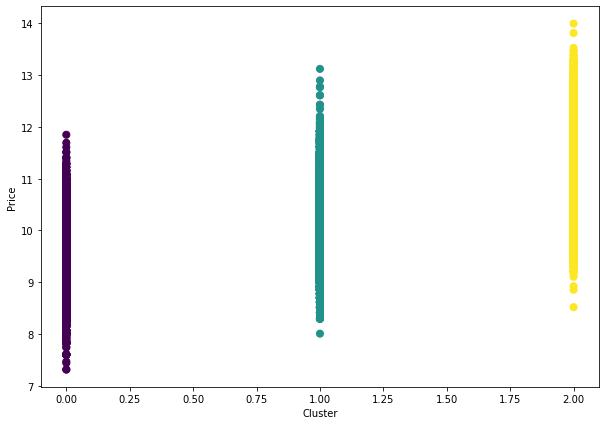

In [51]:
plt.figure(figsize=(10,7))
plt.scatter( x = 'Cluster' ,y = 'price' , data = clustered_renhou, c = label , s = 50 )
plt.xlabel("Cluster")
plt.ylabel("Price")
plt.show()

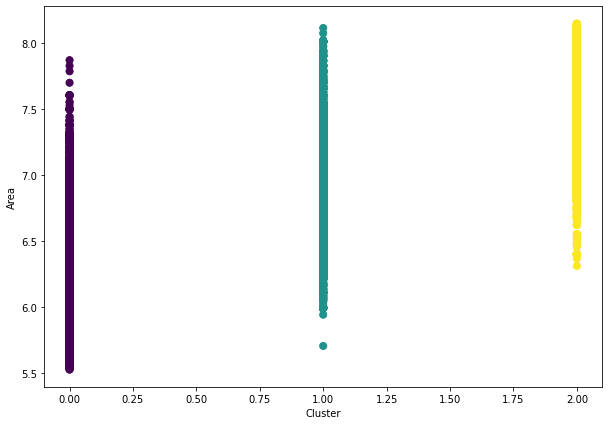

In [52]:
plt.figure(figsize=(10,7))
plt.scatter( x = 'Cluster' ,y = 'area' , data = clustered_renhou, c = label , s = 50 )
plt.xlabel("Cluster")
plt.ylabel("Area")
plt.show()


> From the above two plots between clusters formed by Kmeans and the price and area of properties respectively,we can see that the segmentation has happened by the basis of ascending area and price. The first cluster has the lowest area and priced properties, the second has properties in the mid range and the third contains mostly the expensive ones.  

<AxesSubplot:xlabel='price', ylabel='Count'>

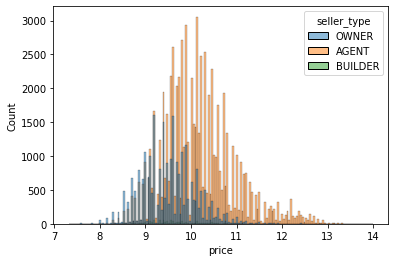

In [53]:
sns.histplot(data=clustered_renhou,x='price',hue='seller_type')

<AxesSubplot:xlabel='price', ylabel='Count'>

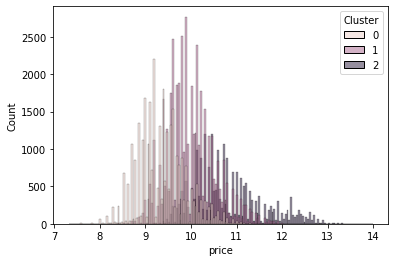

In [54]:
sns.histplot(data=clustered_renhou,x='price',hue='Cluster')

<AxesSubplot:xlabel='area', ylabel='Count'>

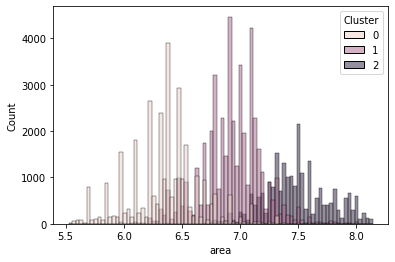

In [55]:
sns.histplot(data=clustered_renhou,x='area',hue='Cluster')

<Figure size 720x504 with 0 Axes>

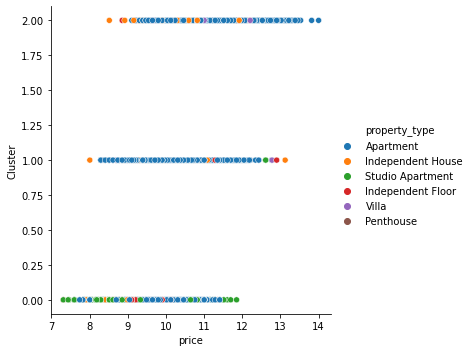

In [56]:
plt.figure(figsize=(10,7))
sns.relplot(data=clustered_renhou,x='price',y='Cluster',hue='property_type')

<Figure size 720x504 with 0 Axes>

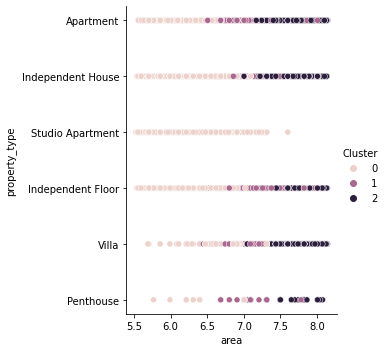

In [57]:
plt.figure(figsize=(10,7))
sns.relplot(data=clustered_renhou,x='area',y='property_type',hue='Cluster')

In [58]:
kmeans=KMeans(n_clusters=8)
label=kmeans.fit_predict(renhou_dummy)
print(label)

[3 4 3 ... 3 1 1]


In [59]:
clustered_renhou2 = renhou.copy()
clustered_renhou2['Cluster'] = label
clustered_renhou2

,seller_type,bedroom,layout_type,property_type,locality,price,area,furnish_type,bathroom,city,Cluster
0,OWNER,2.0,BHK,Apartment,Bodakdev,9.903488,7.279319,Furnished,2.0,Ahmedabad,3
2,OWNER,3.0,BHK,Apartment,Jodhpur,9.998798,7.549609,Unfurnished,3.0,Ahmedabad,4
3,OWNER,2.0,BHK,Independent House,Sanand,9.472705,7.158514,Semi-Furnished,2.0,Ahmedabad,3
4,OWNER,2.0,BHK,Independent House,Navrangpura,9.798127,7.377759,Furnished,2.0,Ahmedabad,3
5,OWNER,1.0,BHK,Apartment,Vejalpur,9.047821,6.345636,Unfurnished,1.0,Ahmedabad,3
...,...,...,...,...,...,...,...,...,...,...,...
193006,OWNER,1.0,BHK,Apartment,Chinchwad,9.491753,6.476972,Semi-Furnished,1.0,Pune,3
193007,OWNER,1.0,RK,Studio Apartment,Wadgaon Sheri,8.853665,5.857933,Unfurnished,1.0,Pune,0
193008,OWNER,1.0,BHK,Apartment,Kothrud,9.047821,5.963579,Semi-Furnished,1.0,Pune,3
193009,AGENT,1.0,BHK,Apartment,Wakad,9.711116,6.507278,Semi-Furnished,2.0,Pune,1


<AxesSubplot:xlabel='Cluster', ylabel='Count'>

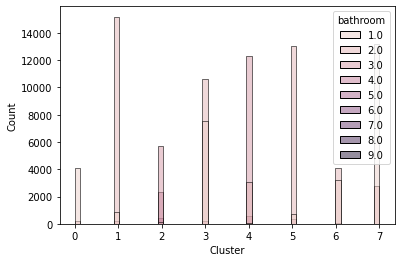

In [60]:
sns.histplot(data=clustered_renhou2,x='Cluster',hue='bathroom')

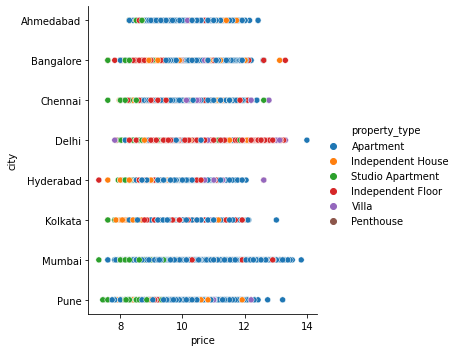

In [61]:
sns.relplot(x='price',y='city',hue='property_type',data=clustered_renhou2)

<Figure size 720x504 with 0 Axes>

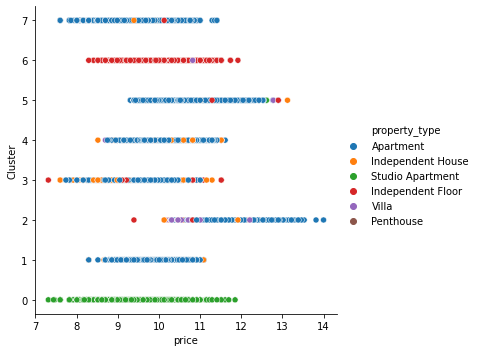

In [62]:
plt.figure(figsize=(10,7))
sns.relplot(data=clustered_renhou2,x='price',y='Cluster',hue='property_type')